# Papyrus Characteristics: Binarization and Impainting

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install tormentor
!pip install kornia==0.5.2
!pip install gpustat
!pip install iunets
!pip install rarfile
!pip install py7zr
!cp -r gdrive/My\ Drive//mt/data/tmp/ ./
!cp ./gdrive/My\ Drive/mt/out/m2/models/bunet_small.pt ./{resume_fname}.best_so_far.pt
!cp ./gdrive/My\ Drive/mt/out/m2/models/bunet_small.pt ./bunet_{arch_size}.pt
!cp ./gdrive/My\ Drive/mt/src/0_13241_4467NR.bmp ./0_10075_3572EV.bmp

     |████████████████████████████████| 474 kB 8.9 MB/s 
  Created wheel for tormentor: filename=tormentor-0.1.2-py2.py3-none-any.whl size=40159 sha256=182a8f4c27571ddea14f4a82932cbc117881530a61bcca84ec451de8f867d32b
  Stored in directory: /root/.cache/pip/wheels/9b/94/22/48e0beb4e8a2acc10d21f987a1f7adc4a1e0d39c27a9564912
  Created wheel for fargv: filename=fargv-0.1.4-py3-none-any.whl size=6394 sha256=ae18b9f7126a986055452132d3732f10b3b432c023708a871dc9380b1dc05550
  Stored in directory: /root/.cache/pip/wheels/b2/05/ee/181ddff8a60def4ef16bd3559bc17c650e6539f6772709f5bd
Successfully built tormentor fargv
     |████████████████████████████████| 279 kB 5.0 MB/s 
  Attempting uninstall: kornia
    Found existing installation: kornia 0.6.3
    Uninstalling kornia-0.6.3:
      Successfully uninstalled kornia-0.6.3
     |████████████████████████████████| 78 kB 3.1 MB/s 
  Created wheel for gpustat: filename=gpustat-0.6.0-py3-none-any.whl size=12617 sha256=7df14be849993b5cb79d73d111dc95a735d

In [ ]:
import iunets
import zipfile
import rarfile
import py7zr
import fargv
from tormentor import *
import tormentor
from PIL import Image, ImageOps
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
from subprocess import getoutput as shell_stdout
import os
import errno
import glob
import sys
import time
import tqdm
import pathlib

import torch
from torch import nn
from torch import nn, autograd, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import skimage
from skimage import io
from skimage.filters import threshold_otsu
from skimage.filters import try_all_threshold
from skimage.restoration import inpaint

## BUnet

In [ ]:
def tensor2pil(tensor):
    tensor = torch.Tensor(tensor) 
    
    if len(tensor.size()) == 4:
        assert tensor.size(0) == 1
        tensor = tensor[0,:,:,:]
    if tensor.size(0) in (1,2):
        tensor = tensor[0, :, :]
    else:
        assert len(tensor.size()) == 2 or tensor.size(0) in (3, 4)
    array = np.uint8(tensor.cpu().numpy().astype("float") * 255)
    return Image.fromarray(array)



class BUNet(nn.Module):
    @staticmethod
    def resume(fname, **kwargs):
        try:
            if "device" in kwargs.keys():
                device = kwargs["device"]
            else:
                device = ""
            state_dict=torch.load(fname, map_location="cpu")
            constructor_params = state_dict["constructor_params"]
            del state_dict["constructor_params"]
            validation_epochs = state_dict["validation_epochs"]
            del state_dict["validation_epochs"]
            train_epochs = state_dict["train_epochs"]
            del state_dict["train_epochs"]
            args_history = state_dict["args_history"]
            del state_dict["args_history"]
            net = BUNet(**constructor_params)
            net.load_state_dict(state_dict)
            net.validation_epochs = validation_epochs
            net.train_epochs = train_epochs
            net.args_history = args_history
            net = net.to(device=device)
            return net
        except FileNotFoundError:
            return BUNet(**kwargs)
        

    def __init__(self, input_channels=3, target_channels=2, channels=(64,128,256,384), stack_size=2, device="cuda") -> None:
        super().__init__()
        self.input2iunet = nn.Conv2d(in_channels=input_channels, out_channels=channels[0], kernel_size=3, padding=1)
        self.iunet2output = nn.Conv2d(in_channels=channels[0], out_channels=target_channels, kernel_size=3, padding=1)
        self.iunet = iunets.iUNet(in_channels=channels[0], channels=channels[1:], architecture=(stack_size,)*(len(channels)-1), dim=2)
        self.train_epochs = []
        self.validation_epochs = {}
        self.constructor_params = {"input_channels":input_channels, "target_channels":target_channels, "channels":channels, "stack_size":stack_size, "device":device}
        self.args_history={}
        self.to(device=device)


    def forward(self, x):
        x = self.input2iunet(x)
        x = self.iunet(x)
        x = self.iunet2output(x)
        return x
    

    def binarize(self, input):
        if isinstance(input, torch.Tensor):
            with torch.no_grad():
                if len(input.size()) == 3:
                    input = torch.unsqueeze(input, 0)
                assert len(input.size()) == 4
                input = input.to(next(self.parameters()).device)
                output = self.forward(input)
                output = (F.softmax(output, dim=1)[0, 1, :,:]).cpu().numpy()
                return output
                #output = (output > .5).astype("float")
                output_img = Image.fromarray(np.uint8(output*255))
                if input.size(1) == 1:
                    input_array = np.uint8(input[0, 0,:,:].cpu().numpy().astype("float") * 255)
                else:
                    input_array = np.uint8(input[0, :,:,:].cpu().numpy().astype("float") * 255)
                input_img = Image.fromarray(input_array)
                return output_img
        elif isinstance(input, DataLoader):
            results = []
            for sample_data in input:
                sample_input_image = sample_data[0]
                #print(type(sample_input_image))
                #print(type(sample_data))
                results.append(tuple([tensor2pil(s) for s in (self.binarize(sample_input_image),)+ tuple(sample_data)]))
            return results
        else:
            raise ValueError("Expect dataloader or dataset")


    def save(self, fname, args=None):
        state_dict = self.state_dict()
        state_dict["constructor_params"] = self.constructor_params
        state_dict["validation_epochs"] = self.validation_epochs
        state_dict["train_epochs"] = self.train_epochs
        state_dict["args_history"] = self.args_history
        torch.save(state_dict, fname)

## Dibco 

In [ ]:
def _get_dict(compressed_stream, filter_gt=False, filter_nongt=False):
    assert not (filter_gt and filter_nongt)
    isimage = lambda x:x.split(".")[-1].lower() in ["tiff", "bmp", "jpg", "tif", "jpeg", "png"] and not "skel" in x.lower()
    isgt = lambda x: isimage(x) and ("gt" in x or "GT" in x)
    if isinstance(compressed_stream, py7zr.SevenZipFile):
        compressed_stream.reset()
        res_dict = compressed_stream.readall()
        names = res_dict.keys()
        if filter_gt:
            names = [n for n in names if not isgt(n)]
        if filter_nongt:
            names = [n for n in names if isgt(n)]
        return {name: res_dict[name] for name in names}
    elif isinstance(compressed_stream, rarfile.RarFile) or isinstance(compressed_stream, zipfile.ZipFile):
        names = compressed_stream.namelist()
        names = [n for n in names if isimage(n)]
        if filter_gt:
            names = [n for n in names if not isgt(n)]
        if filter_nongt:
            names = [n for n in names if isgt(n)]
        return {name: BytesIO(compressed_stream.read(compressed_stream.getinfo(name))) for name in names}
    else:
        raise ValueError("Filedescriptor must be one of [rar, zip, 7z]")


def extract(archive,root=None):
    if archive.endswith(".tar.gz"):
        if root is None:
            cmd="tar -xpvzf {}".format(archive)
        else:
            cmd = 'mkdir -p {};tar -xpvzf {} -C{}'.format(root,archive,root)
        output = shell_stdout(cmd)
    else:
        raise NotImplementedError()


def check_os_dependencies():
    program_list=["wget"]
    return all([shell_stdout("which "+prog) for prog in program_list])

def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def resumable_download(url,save_dir):
    mkdir_p(save_dir)
    download_cmd = 'wget --directory-prefix=%s -c %s' % (save_dir, url)
    print("Downloading {} ... ".format(url))
    shell_stdout(download_cmd)
    print("done")
    return os.path.join(save_dir,url.split("/")[-1])

class SquarePad:
    def __call__(self, image):
        #print(image.shape)
        w= image.shape[1]  
        h= image.shape[2]  
        #print(w,h)      
        max_size =1200
        
        if w > max_size:
            #image = transforms.PILToTensor()(image)
            image = transforms.CenterCrop((h,max_size))(image)
        
        if h > max_size:
            #image = transforms.PILToTensor()(image)
            image = transforms.CenterCrop((max_size,w))(image)
        
        return image

dibco_transform_gray_input = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
    SquarePad(),
    #lambda x: torch.cat([x, 1 - x])
])

dibco_transform_color_input = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    SquarePad(),
    #torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

dibco_transform_gt = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
    SquarePad(),
    lambda x: torch.cat([x, 1 - x])
])


class Dibco:
    """Provides one or more of the `DIBCO <https://vc.ee.duth.gr/dibco2019/>` datasets.

    Os dependencies: Other than python packages, unrar and arepack CLI tools must be installed.
    In Ubuntu they can be installed with: sudo apt install unrar atool p7zip-full
    In order to concatenate two DIBCO datasets just add them:
    .. source :: python

        trainset = dibco.Dibco.Dibco2009() + dibco.Dibco.Dibco2013()
        valset = dibco.Dibco.Dibco2017() + dibco.Dibco.Dibco209()

    Each item is a tuple of an RGB PIL image and an Binary PIL image. The images are transformed by ``input_transform``
    and ``gt_transform``.
    """
    urls = {
        "2009_HW": ["https://users.iit.demokritos.gr/~bgat/DIBCO2009/benchmark/DIBC02009_Test_images-handwritten.rar",
                    "https://users.iit.demokritos.gr/~bgat/DIBCO2009/benchmark/DIBCO2009-GT-Test-images_handwritten.rar"],

        "2009_P": ["https://users.iit.demokritos.gr/~bgat/DIBCO2009/benchmark/DIBCO2009_Test_images-printed.rar",
                   "https://users.iit.demokritos.gr/~bgat/DIBCO2009/benchmark/DIBCO2009-GT-Test-images_printed.rar"],

        "2010": ["http://users.iit.demokritos.gr/~bgat/H-DIBCO2010/benchmark/H_DIBCO2010_test_images.rar",
                 "http://users.iit.demokritos.gr/~bgat/H-DIBCO2010/benchmark/H_DIBCO2010_GT.rar"],

        "2011_P": ["http://utopia.duth.gr/~ipratika/DIBCO2011/benchmark/dataset/DIBCO11-machine_printed.rar"],
        "2011_HW": ["http://utopia.duth.gr/~ipratika/DIBCO2011/benchmark/dataset/DIBCO11-handwritten.rar"],

        "2012": ["http://utopia.duth.gr/~ipratika/HDIBCO2012/benchmark/dataset/H-DIBCO2012-dataset.rar"],

        "2013": ["http://utopia.duth.gr/~ipratika/DIBCO2013/benchmark/dataset/DIBCO2013-dataset.rar"],

        "2014": ["http://users.iit.demokritos.gr/~bgat/HDIBCO2014/benchmark/dataset/original_images.rar",
                 "http://users.iit.demokritos.gr/~bgat/HDIBCO2014/benchmark/dataset/GT.rar"],
        "2016": ["https://vc.ee.duth.gr/h-dibco2016/benchmark/DIBCO2016_dataset-original.zip",
                 "https://vc.ee.duth.gr/h-dibco2016/benchmark/DIBCO2016_dataset-GT.zip"],
        "2017": ["https://vc.ee.duth.gr/dibco2017/benchmark/DIBCO2017_Dataset.7z",
                 "https://vc.ee.duth.gr/dibco2017/benchmark/DIBCO2017_GT.7z"],
        "2018": ["http://vc.ee.duth.gr/h-dibco2018/benchmark/dibco2018_Dataset.zip",
                 "http://vc.ee.duth.gr/h-dibco2018/benchmark/dibco2018-GT.zip"],
        "2019A":["https://vc.ee.duth.gr/dibco2019/benchmark/dibco2019_dataset_trackA.zip",
                 "https://vc.ee.duth.gr/dibco2019/benchmark/dibco2019_gt_trackA.zip"],
        "2019B":["https://vc.ee.duth.gr/dibco2019/benchmark/dibco2019_dataset_trackB.zip",
                 "https://vc.ee.duth.gr/dibco2019/benchmark/dibco2019_GT_trackB.zip"]
    }

    urls = {
        "2009_HW": ["http://rr.visioner.ca/assets/dibco_mirror/DIBC02009_Test_images-handwritten.rar",
                    "http://rr.visioner.ca/assets/dibco_mirror/DIBCO2009-GT-Test-images_handwritten.rar"],
        "2009_P": ["http://rr.visioner.ca/assets/dibco_mirror/DIBCO2009_Test_images-printed.rar",
                   "http://rr.visioner.ca/assets/dibco_mirror/DIBCO2009-GT-Test-images_printed.rar"],
        "2010": ["http://rr.visioner.ca/assets/dibco_mirror/H_DIBCO2010_test_images.rar",
                 "http://rr.visioner.ca/assets/dibco_mirror/H_DIBCO2010_GT.rar"],
        "2011_P": ["http://rr.visioner.ca/assets/dibco_mirror/DIBCO11-machine_printed.rar"],
        "2011_HW": ["http://rr.visioner.ca/assets/dibco_mirror/DIBCO11-handwritten.rar"],
        "2012": ["http://rr.visioner.ca/assets/dibco_mirror/H-DIBCO2012-dataset.rar"],
        "2013": ["http://rr.visioner.ca/assets/dibco_mirror/DIBCO2013-dataset.rar"],
        "2014": ["http://rr.visioner.ca/assets/dibco_mirror/original_images.rar",
                 "http://rr.visioner.ca/assets/dibco_mirror/GT.rar"],
        "2016": ["http://rr.visioner.ca/assets/dibco_mirror/DIBCO2016_dataset-original.zip",
                 "http://rr.visioner.ca/assets/dibco_mirror/DIBCO2016_dataset-GT.zip"],
        "2017": ["http://rr.visioner.ca/assets/dibco_mirror/DIBCO2017_Dataset.7z",
                 "http://rr.visioner.ca/assets/dibco_mirror/DIBCO2017_GT.7z"],
        "2018": ["http://rr.visioner.ca/assets/dibco_mirror/dibco2018_Dataset.zip",
                 "http://rr.visioner.ca/assets/dibco_mirror/dibco2018-GT.zip"],
        "2019A":["http://rr.visioner.ca/assets/dibco_mirror/dibco2019_dataset_trackA.zip",
                 "http://rr.visioner.ca/assets/dibco_mirror/dibco2019_gt_trackA.zip"],
        "2019B":["http://rr.visioner.ca/assets/dibco_mirror/dibco2019_dataset_trackB.zip",
                 "http://rr.visioner.ca/assets/dibco_mirror/dibco2019_GT_trackB.zip"]
    }


    @staticmethod
    def load_single_stream(compressed_stream):
        input_name2bs = _get_dict(compressed_stream, filter_gt=True)
        gt_name2bs = _get_dict(compressed_stream, filter_nongt=True)
        id2gt = {n.split("/")[-1].split("_")[0].split(".")[0]: Image.open(fd).copy() for n, fd in gt_name2bs.items()}
        id2in = {n.split("/")[-1].split("_")[0].split(".")[0]: Image.open(fd).copy() for n, fd in input_name2bs.items()}
        assert set(id2gt.keys()) == set(id2in.keys())
        #id2gt = {k: ImageOps.invert(v.convert("RGB")).convert('1') for k, v in id2gt.items()}
        id2in = {k: v.convert("RGB") for k, v in id2in.items()}
        return {k: (id2in[k], id2gt[k]) for k in id2gt.keys()}

    @staticmethod
    def load_double_stream(input_compressed_stream, gt_compressed_stream):
        input_name2bs = _get_dict(input_compressed_stream)
        gt_name2bs = _get_dict(gt_compressed_stream)
        #del input_name2bs['dataset/14.bmp']
        #del gt_name2bs['dataset/14.bmp']
        id2in = {n.split("/")[-1].split("_")[0].split(".")[0]: Image.open(fd).copy() for n, fd in input_name2bs.items()}
        id2gt = {n.split("/")[-1].split("_")[0].split(".")[0]: Image.open(fd).copy() for n, fd in gt_name2bs.items()}
        assert set(id2gt.keys()) == set(id2in.keys())
        
        #id2gt = {k: ImageOps.invert(v.convert("RGB")).convert('1') for k, v in id2gt.items()}
        id2in = {k: v.convert("RGB") for k, v in id2in.items()}
        return {k: (id2in[k], id2gt[k]) for k in id2gt.keys()}

    @staticmethod
    def Dibco2009(**kwargs):
        kwargs["partitions"] = ["2009_HW", "2009_P"]
        return Dibco(**kwargs)


    @staticmethod
    def Dibco2010(**kwargs):
        kwargs["partitions"] = ["2010"]
        return Dibco(**kwargs)

    @staticmethod
    def Dibco2011(**kwargs):
        kwargs["partitions"] = ["2011_P","2011_HW"]
        return Dibco(**kwargs)

    @staticmethod
    def Dibco2012(**kwargs):
        kwargs["partitions"] = ["2012"]
        return Dibco(**kwargs)

    @staticmethod
    def Dibco2013(**kwargs):
        kwargs["partitions"] = ["2013"]
        return Dibco(**kwargs)

    @staticmethod
    def Dibco2014(**kwargs):
        kwargs["partitions"] = ["2014"]
        return Dibco(**kwargs)

    @staticmethod
    def Dibco2016(**kwargs):
        kwargs["partitions"] = ["2016"]
        return Dibco(**kwargs)

    @staticmethod
    def Dibco2017(**kwargs):
        kwargs["partitions"] = ["2017"]
        return Dibco(**kwargs)

    @staticmethod
    def Dibco2018(**kwargs):
        kwargs["partitions"] = ["2018"]
        return Dibco(**kwargs)

    @staticmethod
    def Dibco2019(**kwargs):
        kwargs["partitions"] = ["2019A","2019B"]
        return Dibco(**kwargs)

    def __init__(self, partitions=["2009_HW", "2009_P"], root="./tmp/dibco", input_transform=dibco_transform_gray_input, gt_transform=dibco_transform_gt, add_mask=False):
        self.input_transform = input_transform
        self.gt_transform = gt_transform
        self.root = root
        self.add_mask = add_mask
        data = {}
        for partition in partitions:
            for url in Dibco.urls[partition]:
                archive_fname = root + "/" + url.split("/")[-1]
                if not os.path.isfile(archive_fname):
                    resumable_download(url, root)
                else:
                    print(archive_fname," found in cache.")
            if len(Dibco.urls[partition]) == 2:
                if Dibco.urls[partition][0].endswith(".rar"):
                    input_rar = rarfile.RarFile(root + "/" + Dibco.urls[partition][0].split("/")[-1])
                    gt_rar = rarfile.RarFile(root + "/" + Dibco.urls[partition][1].split("/")[-1])
                    samples = {partition + "/" + k: v for k, v in Dibco.load_double_stream(input_rar, gt_rar).items()}
                    data.update(samples)
                elif Dibco.urls[partition][0].endswith(".zip") or Dibco.urls[partition][0].endswith(".7z"):
                    zip_input_fname = root + "/" + Dibco.urls[partition][0].split("/")[-1]
                    zip_gt_fname = root + "/" + Dibco.urls[partition][1].split("/")[-1]
                    if zip_input_fname.endswith("7z"):
                        input_zip = py7zr.SevenZipFile(zip_input_fname)
                    else:
                        input_zip = zipfile.ZipFile(zip_input_fname)
                    if zip_gt_fname.endswith("7z"):
                        gt_zip = py7zr.SevenZipFile(zip_gt_fname)
                    else:
                        gt_zip = zipfile.ZipFile(zip_gt_fname)
                    samples = {partition + "/" + k: v for k, v in Dibco.load_double_stream(input_zip, gt_zip).items()}
                    data.update(samples)
                else:
                    raise ValueError("Unknown file type")
            else:
                if Dibco.urls[partition][0].endswith(".rar"):
                    input_rar = rarfile.RarFile(root + "/" + Dibco.urls[partition][0].split("/")[-1])
                    samples = {partition + "/" + k: v for k, v in Dibco.load_single_stream(input_rar).items()}
                    data.update(samples)
                elif Dibco.urls[partition][0].endswith(".zip") or Dibco.urls[partition][0].endswith(".7z"):
                    zip_input_fname = root + "/" + Dibco.urls[partition][0].split("/")[-1]
                    if zip_input_fname.endswith("7z"):
                        # zip_input_fname = zip_input_fname[:-2] + "zip"
                        input_zip = py7zr.SevenZipFile(zip_input_fname)
                    else:
                        input_zip = zipfile.ZipFile(zip_input_fname)
                    samples = {partition + "/" + k: v for k, v in Dibco.load_single_stream(input_zip).items()}
                    data.update(samples)
                else:
                    raise ValueError("Unknown file type")
        id_data = list(data.items())
        self.sample_ids = [sample[0] for sample in id_data]
        self.inputs = [sample[1][0] for sample in id_data]
        self.gt = [sample[1][1] for sample in id_data]

    def __getitem__(self, item):
        input_img = self.input_transform(self.inputs[item])
        gt = self.gt_transform(self.gt[item])
        if self.add_mask:
            return input_img, gt, torch.ones_like(input_img[:1, :, :])
        else:
            return input_img, gt

    def __len__(self):
        return len(self.sample_ids)

    def __add__(self, other):
        res = Dibco(partitions=[])
        res.root = self.root
        res.input_transform = self.input_transform
        res.gt_transform = self.gt_transform
        res.sample_ids = self.sample_ids + other.sample_ids
        res.inputs = self.inputs + other.inputs
        res.gt = self.gt + other.gt
        return res


## Training

In [ ]:
def binarization_fscores(retrieved, relevant, epsilon=.0000000001):
    """Measures binarization FScores for one or more samples

    Args:
        retrieved (torch.tensor): The predictions tensor where 0 is the background and 1 is the foreground. The tensor represent a batch sized either [BxHxW] or [Bx1xHxW].
        relevant (torch.tensor): The ground-truth tensor where 0 is the background and 1 is the foreground. The tensor represent a batch sized either [BxHxW] or [Bx1xHxW].
        epsilon (float, optional): A value added to the nominator and the denominator to deal with numerical instabillity. Defaults to .0000000001.

    Returns:
        (torch.Tensor, torch.Tensor, torch.Tensor): A tuple of 1D torch tensors with the fscore, precision and recall of each sample.
    """
    assert retrieved.size() == relevant.size()
    assert (len(retrieved.size()) == 3) or ((len(retrieved.size()) == 4))
    if retrieved.size(1) == 2:
        retrieved = retrieved[:, 0, :, :] > retrieved[:, 1, :, :]
    if relevant.size(1) == 2:
        relevant = relevant[:, 0, :, :] > relevant[:, 1, :, :]
    retrieved = ~retrieved
    relevant = ~relevant
    batch_sz = retrieved.size(0)
    retrieved = retrieved.view([batch_sz, -1])
    relevant = relevant.view([batch_sz, -1])
    true_positives = (retrieved * relevant)
    precisions = ((true_positives.sum(dim=1).float()+epsilon)/(retrieved.sum(dim=1).float()+epsilon))
    recalls = ((true_positives.sum(dim=1).float()+epsilon)/(relevant.sum(dim=1).float()+epsilon))
    fscores = (2*precisions*recalls+epsilon)/(precisions+recalls+epsilon)
    return fscores, precisions, recalls

In [ ]:
def train_epoch(net, dataloader, loss_fn, optimizer):
    net.train(True)
    device = next(net.parameters()).device
    epoch_losses = []
    epoch_fscores = []
    t=time.time()
    if len(net.train_epochs)>0:
        desc=f"Training {len(net.train_epochs):5d} loss: {net.train_epochs[-1]['loss']:.6f} FM: {net.train_epochs[-1]['fscore']:.6f}"
    else:
        desc = 'NA'
    for inputs, targets in tqdm.tqdm(dataloader, desc=desc):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        loss = loss_fn(outputs, targets)
        epoch_losses.append(loss.detach())
        loss.sum().backward()
        test = outputs.detach()
        print()
        epoch_fscores.append(binarization_fscores(outputs.detach(), targets.detach())[0])
        optimizer.step()
        optimizer.zero_grad()
    total_time = time.time() - t
    epoch_fscore = float(torch.cat(epoch_fscores, dim=0).mean())
    epoch_loss = float(torch.stack(epoch_losses).mean())
    net.train_epochs.append({"loss":epoch_loss, "fscore":epoch_fscore, "duration":total_time,"time":time.time()})

In [ ]:
def validate_otsu(dataloader):
    with torch.no_grad():
        otsu_fscores = []
        oracle_fscores = []
        t=time.time()
        for inputs, targets in tqdm.tqdm(dataloader, desc="Otsu"):
            inputs, targets = inputs.cpu(), targets.cpu()
            otsu_thr = threshold_otsu((inputs*255.).numpy().astype("uint8")[0,0, :, :]) / 255.
            oracle_fscores.append(max([binarization_fscores(inputs>thr, targets.detach()[:,1:,:,:]<.5)[0] for thr in np.linspace(0,1, 255).tolist()]))
            otsu_fscores.append(binarization_fscores(inputs>otsu_thr, targets.detach()[:,1:,:,:]<.5)[0])
        otsu_fscore = float(torch.cat(otsu_fscores, dim=0).mean())
        oracle_fscore = float(torch.stack(oracle_fscores).mean())
        #print(f"Validation Otsu FM:{otsu_fscore:.6f} Oracle FM: {oracle_fscore:.6f}")
        return otsu_fscore, oracle_fscore

## Save images folder

In [ ]:
def save_images_infolder(image_list, folder):
    #print(folder)
    pathlib.Path('./tmp/validation_images/').mkdir(parents=True, exist_ok=True)
    for n, image in enumerate(image_list):
        if isinstance(image, Image.Image):            
            filename = str(pathlib.Path(folder).joinpath(f"{n:05d}.png"))
            #print(filename)
            image.save(filename)
        elif isinstance(image, tuple):
            images = image
            for partition, image in enumerate(images):
                filename = './' + str(pathlib.Path(folder).joinpath(f"{n:05d}_{partition:02d}.png"))
                #print(filename)                
                image.save(filename)

In [ ]:
def validate_epoch(net, dataloader, loss_fn, store_in_net=True):
    with torch.no_grad():
        net.train(False)
        device = next(net.parameters()).device
        epoch_losses = []
        epoch_fscores = []
        t=time.time()
        if len(net.train_epochs)>0:
            desc=f"Train loss: {net.train_epochs[-1]['loss']:.6f} FM: {net.train_epochs[-1]['fscore']:.6f}"
        else:
            desc = 'NA'
        for inputs, targets in tqdm.tqdm(dataloader, desc=desc):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = loss_fn(outputs, targets)
            epoch_losses.append(loss.detach())
            epoch_fscores.append(binarization_fscores(outputs.detach(), targets.detach())[0])
        total_time = time.time() - t
        epoch_fscore = float(torch.cat(epoch_fscores, dim=0).mean())
        epoch_loss = float(torch.stack(epoch_losses).mean())
       # warn(f"Validation {len(net.train_epochs):5d} loss: {epoch_loss:.6f} FM: {epoch_fscore:.6f}")
        if store_in_net:
            net.validation_epochs[len(net.train_epochs)] = {"loss":epoch_loss, "fscore":epoch_fscore, "duration":total_time,"time":time.time()}
        return epoch_fscore, epoch_fscore

In [ ]:
def load_dataset(dataset_name:str):
    if dataset_name == "synth":
        images = [torch.Tensor(np.array(Image.open(fname))[:,:,0]/255.).unsqueeze(dim=0) for fname in glob.glob("tmp/synth_pages//*png")]
        return [(img, torch.cat([(img>0.99607843).float(), (~(img>0.99607843)).float()])) for img in images]
    if dataset_name == "dibco2009":
        return Dibco.Dibco2009()
    elif dataset_name == "dibco2010":
        return Dibco.Dibco2010()
    elif dataset_name == "dibco2011":
        return Dibco.Dibco2011()
    elif dataset_name == "dibco2012":
        return Dibco.Dibco2012()
    elif dataset_name == "dibco2013":
        return Dibco.Dibco2013()
    elif dataset_name == "dibco2014":
        return Dibco.Dibco2014()
    elif dataset_name == "dibco2016":
        return Dibco.Dibco2016()
    elif dataset_name == "dibco2017":
        return Dibco.Dibco2017()
    elif dataset_name == "dibco2018":
        return Dibco.Dibco2018()
    elif dataset_name == "dibco2019":
        return Dibco.Dibco2019()
    elif dataset_name == "<dibco2018":
        return Dibco.Dibco2019()+Dibco.Dibco2018()+Dibco.Dibco2017()+Dibco.Dibco2016()+Dibco.Dibco2013()+Dibco.Dibco2012()+Dibco.Dibco2011()+Dibco.Dibco2010()+Dibco.Dibco2009()
    elif dataset_name == ">dibco2010":
        return Dibco.Dibco2019()+Dibco.Dibco2018()+Dibco.Dibco2017()+Dibco.Dibco2016()+Dibco.Dibco2013()+Dibco.Dibco2012()+Dibco.Dibco2011()+Dibco.Dibco2010()+Dibco.Dibco2009()
    else:
        raise ValueError

In [ ]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

## Load parameters

In [ ]:
params = {
    "lr_decay_gamma":.995,
    "mode": "train",
    "arch_size": "small",
    "trainset": "dibco2019",
    "validationset": "dibco2019",
    "testset": "dibco2011",
    "resume_fname": "bunet_{arch_size}.pt",
    "bestfound_fname": "{resume_fname}.best_so_far.pt",
    "lr":.01,
    "epochs":102,
    "batch_sz":1,
    "input_channels":1,
    "target_channels":2,
    "save_freq":5,
    "validation_freq":5,
    "validation_dump_freq":1,
    "validation_folder":"./tmp/validation_images/",
    "train_dump_freq":0,
    "train_folder":"/tmp/train_images",
    "device":"cuda",
    "augmentation_str": "tormentor.RandomPlasmaShadow  ^ tormentor.RandomPlasmaContrast  ^ tormentor.RandomIdentity ^ tormentor.RandomFlip ^ tormentor.RandomBrightness ^ tormentor.RandomWrap ^ tormentor.RandomShred"
}
args = dotdict(params)

## Start

In [ ]:
validationset = load_dataset(args.validationset)
valloader = DataLoader(validationset, batch_size=args.batch_sz)

if args.mode in ["train", "test", "inference"]: # a model is loaded for training or testing
    if args.arch_size == "small":
        channels, stack_size = (64, 128, 256, 384), 2
    elif args.arch_size == "deep":
        channels, stack_size = (64, 128, 256, 384), 4
    elif args.arch_size == "wide":
        channels, stack_size = (64, 128, 256, 512, 1024), 2
    elif args.arch_size == "medium":
        channels, stack_size = (64, 128, 256, 512), 3
    elif args.arch_size == "large":
        channels, stack_size = (64, 128, 256, 512, 1024), 4
    else:
        print(args.arch_size)
        raise ValueError


    net = BUNet.resume(args.resume_fname, input_channels=args.input_channels, target_channels=args.target_channels, device=args.device, channels=channels, stack_size=stack_size)
    print(type(net))
    #net.args_history[len(net.train_epochs)] = args


if args.mode == "train":
    trainset = load_dataset(args.trainset)
    trainloader = DataLoader(trainset, batch_size=args.batch_sz)
    if args.augmentation_str == '':
        args.augmentation_str = "Identity"
    if args.augmentation_str == 'flat_plasma':
        args.augmentation_str = "(RandomPlasmaBrightness ^ RandomIdentity ^ RandomPlasmaLinearColor ^ RandomPlasmaContrast ^ RandomPlasmaGaussianAdditiveNoise ^ RandomPlasmaShadow ^ RandomWrap ^ RandomShredInside ^ RandomShredOutside ^ RandomShred)"
    if args.augmentation_str == 'routing_plasma':
        args.augmentation_str = "((RandomIdentity.custom() ^ RandomIdentity.custom() ^ RandomPlasmaLinearColor.custom(roughness=Uniform(value_range=(0.1, 0.4)), alpha_range=Uniform(value_range=(0.0, 1.0)), alpha_mean=Uniform(value_range=(0.0, 1.0)), beta_range=Uniform(value_range=(0.0, 1.0)), beta_mean=Uniform(value_range=(0.0, 1.0)))) | (RandomIdentity.custom() ^ RandomIdentity.custom() ^ RandomShredInside.custom(roughness=Uniform(value_range=(0.4, 0.8)), erase_percentile=Uniform(value_range=(0.0, 0.2))) ^ RandomShredOutside.custom(roughness=Uniform(value_range=(0.1, 0.7)), erase_percentile=Uniform(value_range=(0.0, 0.5)))) | RandomLinearColor.custom(a=Uniform(value_range=(0.6, 0.668)), b=Uniform(value_range=(0.0, 1.0))) | (RandomIdentity.custom() ^ RandomPlasmaShadow.custom(roughness=Uniform(value_range=(0.1, 0.7)), shade_intensity=Uniform(value_range=(-0.51, 0.0)), shade_quantity=Uniform(value_range=(0.0, 1.0)))) | RandomPlasmaBrightness.custom(roughness=Uniform(value_range=(0.1, 0.7)), intensity=Uniform(value_range=(0.0, 0.27))) | (RandomIdentity.custom() ^ RandomPerspective.custom(x_offset=Uniform(value_range=(0.75, 1.5)), y_offset=Uniform(value_range=(0.75, 1.5))) ^ RandomWrap.custom(roughness=Uniform(value_range=(0.1, 0.7)), intensity=Uniform(value_range=(0.0, 1.0))) ^ RandomWrap.custom(roughness=Uniform(value_range=(0.1, 0.7)), intensity=Uniform(value_range=(0.0, 1.0)))))"
    if args.augmentation_str == 'simple_aug':
        args.augmentation_str = 'RandomFlip ^ RandomRotate ^ RandomBrightness ^ Invert ^ Saturation ^ Identity'
    augmentations = eval(args.augmentation_str)
    if args.augmentation_str != '':
        trainloader = tormentor.AugmentedDataLoader(trainloader, augmentations, computation_device=args.device)


    optimizer = optim.Adam(params=net.parameters(), lr=args.lr)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=args.lr_decay_gamma)
    loss_fn = nn.BCEWithLogitsLoss()
    if len(net.train_epochs) == 0:
        validate_epoch(net, valloader, loss_fn)
    if args.mode == "train":
        for epoch in range(len(net.train_epochs), args.epochs):
            train_epoch(net, trainloader, loss_fn, optimizer)
            net.train_epochs[-1]["lr"] = lr_scheduler.get_lr()
            lr_scheduler.step()
            if epoch % args.validation_freq == 0 or epoch == args.epochs -1:
                current_fscore = validate_epoch(net, valloader, loss_fn)[0]
                old_validations = [net.validation_epochs[k]["fscore"] for k in sorted(net.validation_epochs.keys())[:-1]] +[0.]
                if current_fscore > max(old_validations):
                    net.save(args.bestfound_fname)

            if args.validation_dump_freq > 0 and epoch % args.validation_dump_freq == 0 or epoch == args.epochs -1:
                images = net.binarize(valloader)
                #print(len(images))
                #print(type(images[0]))
                #print(images[0].shape)
                
                save_images_infolder(images, args.validation_folder)
            if args.train_dump_freq > 0 and epoch % args.train_dump_freq == 0 or epoch == args.epochs -1:
                images = net.binarize(trainloader)
                save_images_infolder(images, args.train_folder)

            if epoch % args.save_freq == 0 or epoch == args.epochs -1:
                net.save(args.resume_fname)
elif args.mode == "test":
    loss_fn = nn.BCEWithLogitsLoss()
    fscore = validate_epoch(net, valloader, loss_fn)[0]
    print(f"{args.resume_fname}, {args.validationset}: FS:{100*fscore:6.3f} %")
elif args.mode == "otsu_eval":
    otsu_fscore, oracle_fscore = validate_otsu(valloader)
    print(f"Otsu, {args.validationset}: FS:{100*otsu_fscore:6.3f} %")
    print(f"Oracle, {args.validationset}: FS:{100*oracle_fscore:6.3f} %")
    

./tmp/dibco/dibco2019_dataset_trackA.zip  found in cache.
./tmp/dibco/dibco2019_gt_trackA.zip  found in cache.
./tmp/dibco/dibco2019_dataset_trackB.zip  found in cache.
./tmp/dibco/dibco2019_GT_trackB.zip  found in cache.
<class '__main__.BUNet'>
./tmp/dibco/dibco2019_dataset_trackA.zip  found in cache.
./tmp/dibco/dibco2019_gt_trackA.zip  found in cache.
./tmp/dibco/dibco2019_dataset_trackB.zip  found in cache.
./tmp/dibco/dibco2019_GT_trackB.zip  found in cache.


Training    96 loss: 0.397149 FM: 0.478596:   5%|▌         | 1/20 [00:00<00:14,  1.31it/s]

Training    96 loss: 0.397149 FM: 0.478596:  10%|█         | 2/20 [00:00<00:07,  2.32it/s]

Training    96 loss: 0.397149 FM: 0.478596:  15%|█▌        | 3/20 [00:01<00:05,  2.92it/s]

Training    96 loss: 0.397149 FM: 0.478596:  20%|██        | 4/20 [00:01<00:08,  1.97it/s]

Training    96 loss: 0.397149 FM: 0.478596:  25%|██▌       | 5/20 [00:02<00:07,  2.10it/s]

Training    96 loss: 0.397149 FM: 0.478596:  35%|███▌      | 7/20 [00:02<00:04,  2.91it/s]

Training    96 loss: 0.397149 FM: 0.478596:  45%|████▌     | 9/20 [00:03<00:02,  4.10it/s]

Training    96 loss: 0.397149 FM: 0.478596:  50%|█████     | 10/20 [00:03<00:02,  4.84it/s]

Training    96 loss: 0.397149 FM: 0.478596:  55%|█████▌    | 11/20 [00:05<00:06,  1.43it/s]

Training    96 loss: 0.397149 FM: 0.478596:  60%|██████    | 12/20 [00:06<00:08,  1.03s/it]

Training    96 loss: 0.397149 FM: 0.478596:  65%|██████▌   | 13/20 [00:07<00:07,  1.02s/it]

Training    96 loss: 0.397149 FM: 0.478596:  70%|███████   | 14/20 [00:10<00:08,  1.49s/it]

Training    96 loss: 0.397149 FM: 0.478596:  75%|███████▌  | 15/20 [00:11<00:06,  1.40s/it]

Training    96 loss: 0.397149 FM: 0.478596:  80%|████████  | 16/20 [00:12<00:04,  1.19s/it]

Training    96 loss: 0.397149 FM: 0.478596:  85%|████████▌ | 17/20 [00:14<00:04,  1.43s/it]

Training    96 loss: 0.397149 FM: 0.478596:  90%|█████████ | 18/20 [00:15<00:02,  1.23s/it]

Training    96 loss: 0.397149 FM: 0.478596:  95%|█████████▌| 19/20 [00:16<00:01,  1.24s/it]

Training    96 loss: 0.397149 FM: 0.478596: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


Training    97 loss: 0.425891 FM: 0.262730:   5%|▌         | 1/20 [00:00<00:07,  2.46it/s]

Training    97 loss: 0.425891 FM: 0.262730:  10%|█         | 2/20 [00:00<00:05,  3.48it/s]

Training    97 loss: 0.425891 FM: 0.262730:  15%|█▌        | 3/20 [00:00<00:04,  3.84it/s]

Training    97 loss: 0.425891 FM: 0.262730:  20%|██        | 4/20 [00:01<00:07,  2.20it/s]

Training    97 loss: 0.425891 FM: 0.262730:  25%|██▌       | 5/20 [00:02<00:06,  2.26it/s]

Training    97 loss: 0.425891 FM: 0.262730:  35%|███▌      | 7/20 [00:02<00:04,  3.15it/s]

Training    97 loss: 0.425891 FM: 0.262730:  45%|████▌     | 9/20 [00:02<00:02,  4.36it/s]

Training    97 loss: 0.425891 FM: 0.262730:  50%|█████     | 10/20 [00:02<00:01,  5.12it/s]

Training    97 loss: 0.425891 FM: 0.262730:  55%|█████▌    | 11/20 [00:04<00:06,  1.46it/s]

Training    97 loss: 0.425891 FM: 0.262730:  60%|██████    | 12/20 [00:06<00:08,  1.02s/it]

Training    97 loss: 0.425891 FM: 0.262730:  65%|██████▌   | 13/20 [00:07<00:07,  1.01s/it]

Training    97 loss: 0.425891 FM: 0.262730:  70%|███████   | 14/20 [00:09<00:08,  1.42s/it]

Training    97 loss: 0.425891 FM: 0.262730:  75%|███████▌  | 15/20 [00:11<00:06,  1.35s/it]

Training    97 loss: 0.425891 FM: 0.262730:  80%|████████  | 16/20 [00:11<00:04,  1.16s/it]

Training    97 loss: 0.425891 FM: 0.262730:  85%|████████▌ | 17/20 [00:13<00:04,  1.41s/it]

Training    97 loss: 0.425891 FM: 0.262730:  90%|█████████ | 18/20 [00:14<00:02,  1.22s/it]

Training    97 loss: 0.425891 FM: 0.262730:  95%|█████████▌| 19/20 [00:15<00:01,  1.23s/it]

Training    97 loss: 0.425891 FM: 0.262730: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Training    98 loss: 0.393109 FM: 0.415175:   5%|▌         | 1/20 [00:00<00:07,  2.62it/s]

Training    98 loss: 0.393109 FM: 0.415175:  10%|█         | 2/20 [00:00<00:04,  3.61it/s]

Training    98 loss: 0.393109 FM: 0.415175:  15%|█▌        | 3/20 [00:00<00:04,  3.89it/s]

Training    98 loss: 0.393109 FM: 0.415175:  20%|██        | 4/20 [00:01<00:07,  2.26it/s]

Training    98 loss: 0.393109 FM: 0.415175:  25%|██▌       | 5/20 [00:01<00:06,  2.28it/s]

Training    98 loss: 0.393109 FM: 0.415175:  35%|███▌      | 7/20 [00:02<00:04,  3.14it/s]

Training    98 loss: 0.393109 FM: 0.415175:  45%|████▌     | 9/20 [00:02<00:02,  4.30it/s]

Training    98 loss: 0.393109 FM: 0.415175:  50%|█████     | 10/20 [00:02<00:01,  5.03it/s]

Training    98 loss: 0.393109 FM: 0.415175:  55%|█████▌    | 11/20 [00:04<00:06,  1.47it/s]

Training    98 loss: 0.393109 FM: 0.415175:  60%|██████    | 12/20 [00:06<00:08,  1.02s/it]

Training    98 loss: 0.393109 FM: 0.415175:  65%|██████▌   | 13/20 [00:07<00:07,  1.02s/it]

Training    98 loss: 0.393109 FM: 0.415175:  70%|███████   | 14/20 [00:09<00:08,  1.43s/it]

Training    98 loss: 0.393109 FM: 0.415175:  75%|███████▌  | 15/20 [00:11<00:06,  1.36s/it]

Training    98 loss: 0.393109 FM: 0.415175:  80%|████████  | 16/20 [00:11<00:04,  1.16s/it]

Training    98 loss: 0.393109 FM: 0.415175:  85%|████████▌ | 17/20 [00:13<00:04,  1.42s/it]

Training    98 loss: 0.393109 FM: 0.415175:  90%|█████████ | 18/20 [00:14<00:02,  1.22s/it]

Training    98 loss: 0.393109 FM: 0.415175:  95%|█████████▌| 19/20 [00:15<00:01,  1.24s/it]

Training    98 loss: 0.393109 FM: 0.415175: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


Training    99 loss: 0.424711 FM: 0.439279:   5%|▌         | 1/20 [00:00<00:07,  2.49it/s]

Training    99 loss: 0.424711 FM: 0.439279:  15%|█▌        | 3/20 [00:00<00:04,  3.85it/s]

Training    99 loss: 0.424711 FM: 0.439279:  20%|██        | 4/20 [00:01<00:07,  2.21it/s]

Training    99 loss: 0.424711 FM: 0.439279:  25%|██▌       | 5/20 [00:02<00:06,  2.24it/s]

Training    99 loss: 0.424711 FM: 0.439279:  35%|███▌      | 7/20 [00:02<00:04,  3.16it/s]

Training    99 loss: 0.424711 FM: 0.439279:  45%|████▌     | 9/20 [00:02<00:02,  4.39it/s]

Training    99 loss: 0.424711 FM: 0.439279:  50%|█████     | 10/20 [00:02<00:01,  5.11it/s]

Training    99 loss: 0.424711 FM: 0.439279:  55%|█████▌    | 11/20 [00:04<00:06,  1.47it/s]

Training    99 loss: 0.424711 FM: 0.439279:  60%|██████    | 12/20 [00:06<00:08,  1.01s/it]

Training    99 loss: 0.424711 FM: 0.439279:  65%|██████▌   | 13/20 [00:07<00:07,  1.01s/it]

Training    99 loss: 0.424711 FM: 0.439279:  70%|███████   | 14/20 [00:09<00:08,  1.43s/it]

Training    99 loss: 0.424711 FM: 0.439279:  75%|███████▌  | 15/20 [00:11<00:06,  1.35s/it]

Training    99 loss: 0.424711 FM: 0.439279:  80%|████████  | 16/20 [00:11<00:04,  1.16s/it]

Training    99 loss: 0.424711 FM: 0.439279:  85%|████████▌ | 17/20 [00:13<00:04,  1.40s/it]

Training    99 loss: 0.424711 FM: 0.439279:  90%|█████████ | 18/20 [00:14<00:02,  1.21s/it]

Training    99 loss: 0.424711 FM: 0.439279:  95%|█████████▌| 19/20 [00:15<00:01,  1.23s/it]

Training    99 loss: 0.424711 FM: 0.439279: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Training   100 loss: 0.404043 FM: 0.370729:  10%|█         | 2/20 [00:00<00:04,  3.63it/s]

Training   100 loss: 0.404043 FM: 0.370729:  15%|█▌        | 3/20 [00:00<00:04,  3.83it/s]

Training   100 loss: 0.404043 FM: 0.370729:  20%|██        | 4/20 [00:01<00:07,  2.24it/s]

Training   100 loss: 0.404043 FM: 0.370729:  25%|██▌       | 5/20 [00:01<00:06,  2.26it/s]

Training   100 loss: 0.404043 FM: 0.370729:  35%|███▌      | 7/20 [00:02<00:04,  3.17it/s]

Training   100 loss: 0.404043 FM: 0.370729:  45%|████▌     | 9/20 [00:02<00:02,  4.30it/s]

Training   100 loss: 0.404043 FM: 0.370729:  50%|█████     | 10/20 [00:02<00:01,  5.00it/s]

Training   100 loss: 0.404043 FM: 0.370729:  55%|█████▌    | 11/20 [00:04<00:06,  1.45it/s]

Training   100 loss: 0.404043 FM: 0.370729:  60%|██████    | 12/20 [00:06<00:08,  1.02s/it]

Training   100 loss: 0.404043 FM: 0.370729:  65%|██████▌   | 13/20 [00:07<00:07,  1.02s/it]

Training   100 loss: 0.404043 FM: 0.370729:  70%|███████   | 14/20 [00:09<00:08,  1.45s/it]

Training   100 loss: 0.404043 FM: 0.370729:  75%|███████▌  | 15/20 [00:11<00:06,  1.38s/it]

Training   100 loss: 0.404043 FM: 0.370729:  80%|████████  | 16/20 [00:11<00:04,  1.17s/it]

Training   100 loss: 0.404043 FM: 0.370729:  85%|████████▌ | 17/20 [00:13<00:04,  1.41s/it]

Training   100 loss: 0.404043 FM: 0.370729:  90%|█████████ | 18/20 [00:14<00:02,  1.22s/it]

Training   100 loss: 0.404043 FM: 0.370729:  95%|█████████▌| 19/20 [00:15<00:01,  1.24s/it]

Training   100 loss: 0.404043 FM: 0.370729: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


Training   101 loss: 0.356327 FM: 0.502391:   5%|▌         | 1/20 [00:00<00:07,  2.52it/s]

Training   101 loss: 0.356327 FM: 0.502391:  15%|█▌        | 3/20 [00:00<00:04,  3.82it/s]

Training   101 loss: 0.356327 FM: 0.502391:  20%|██        | 4/20 [00:01<00:07,  2.19it/s]

Training   101 loss: 0.356327 FM: 0.502391:  25%|██▌       | 5/20 [00:02<00:06,  2.22it/s]

Training   101 loss: 0.356327 FM: 0.502391:  35%|███▌      | 7/20 [00:02<00:04,  3.12it/s]

Training   101 loss: 0.356327 FM: 0.502391:  45%|████▌     | 9/20 [00:02<00:02,  4.36it/s]

Training   101 loss: 0.356327 FM: 0.502391:  50%|█████     | 10/20 [00:02<00:01,  5.13it/s]

Training   101 loss: 0.356327 FM: 0.502391:  55%|█████▌    | 11/20 [00:04<00:06,  1.44it/s]

Training   101 loss: 0.356327 FM: 0.502391:  60%|██████    | 12/20 [00:06<00:08,  1.04s/it]

Training   101 loss: 0.356327 FM: 0.502391:  65%|██████▌   | 13/20 [00:07<00:07,  1.04s/it]

Training   101 loss: 0.356327 FM: 0.502391:  70%|███████   | 14/20 [00:09<00:08,  1.44s/it]

Training   101 loss: 0.356327 FM: 0.502391:  75%|███████▌  | 15/20 [00:11<00:06,  1.36s/it]

Training   101 loss: 0.356327 FM: 0.502391:  80%|████████  | 16/20 [00:11<00:04,  1.17s/it]

Training   101 loss: 0.356327 FM: 0.502391:  85%|████████▌ | 17/20 [00:13<00:04,  1.41s/it]

Training   101 loss: 0.356327 FM: 0.502391:  90%|█████████ | 18/20 [00:14<00:02,  1.21s/it]

Training   101 loss: 0.356327 FM: 0.502391:  95%|█████████▌| 19/20 [00:15<00:01,  1.23s/it]

Training   101 loss: 0.356327 FM: 0.502391: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


Train loss: 0.281869 FM: 0.439893: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


TypeError: ignored

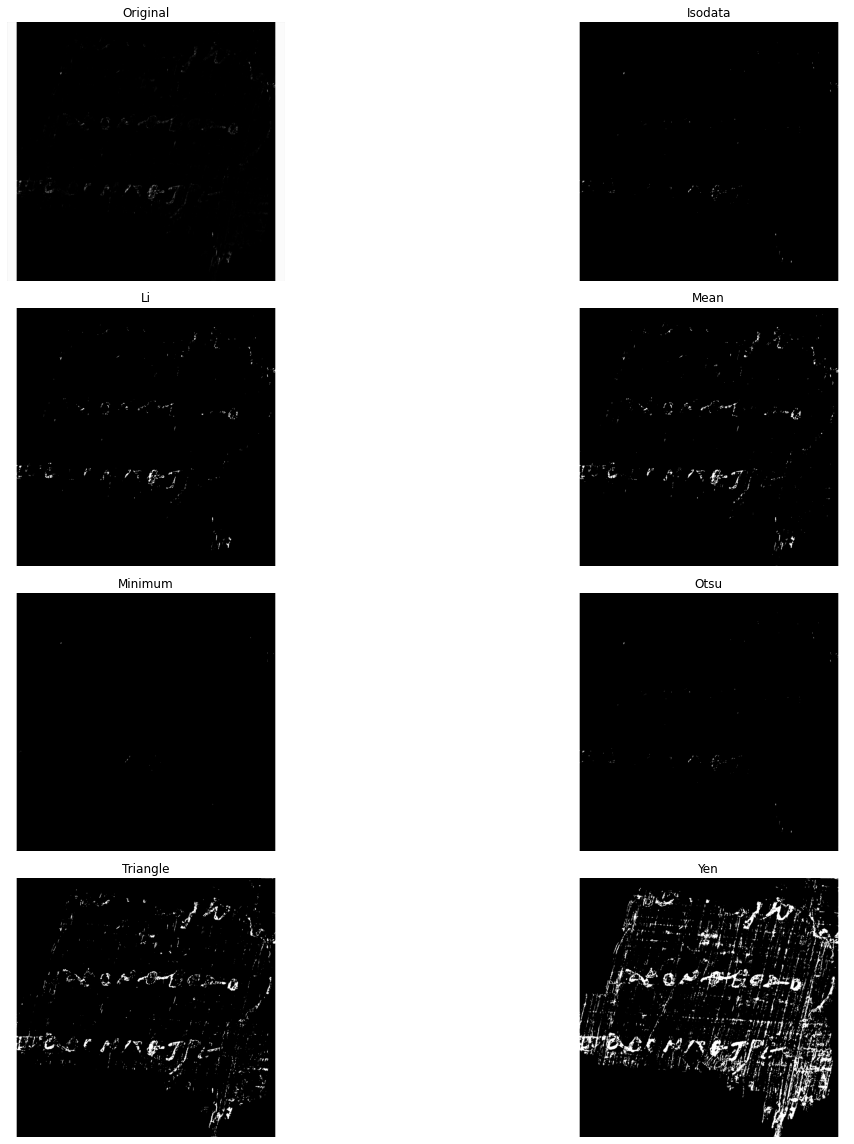

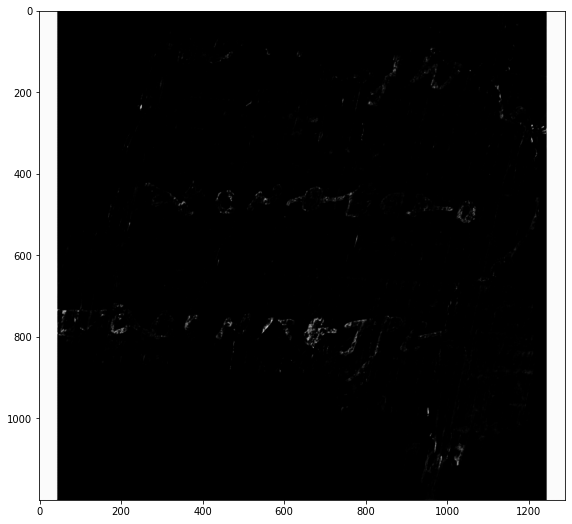

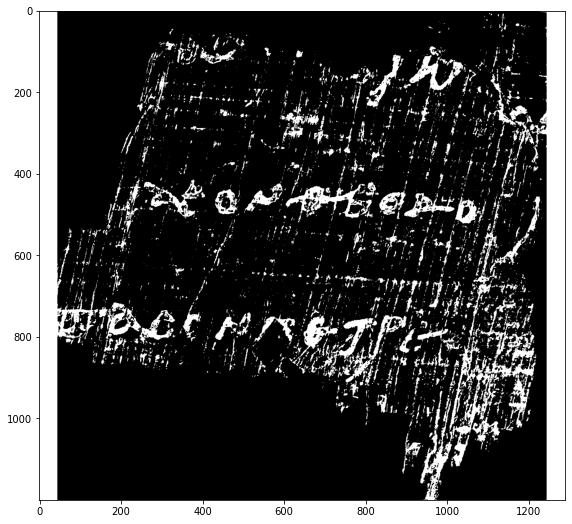

In [ ]:
input_image = Image.open('./0_10075_3572EV.bmp')
image_tensor = dibco_transform_gray_input(input_image)
image_tensor = image_tensor[None, :]
#image_tensor = image_tensor.cuda()
result = net.binarize(image_tensor)
if True:
    fig, ax = try_all_threshold(result, figsize=(20, 16), verbose=False)
if True:
    plt.figure(figsize=(21,9))
    plt.imshow(result, cmap='gray')
    plt.show()

thresh = skimage.filters.threshold_yen(result)
binary = result > thresh
#mask = np.array([binary,np.zeros_like(binary),np.zeros_like(binary)])
#io.imshow(mask)
#mask = np.moveaxis(mask, 0, -1)
if True:
    plt.figure(figsize=(21,9))
    plt.imshow(binary, cmap='gray')
    plt.show()
image_defect = io.imread('./0_10075_3572EV.bmp')
image_tensor = dibco_transform_color_input(image_defect)
defect = image_tensor.numpy()
defect = np.moveaxis(defect, 0, -1)

if False:
    image_result = inpaint.inpaint_biharmonic(defect, mask)
if False:
    io.imsave('mask.png',binary)
    io.imsave('image.png', defect)

In [ ]:
#io.imsave('./data_for_prediction/1224276_original.jpg', defect)

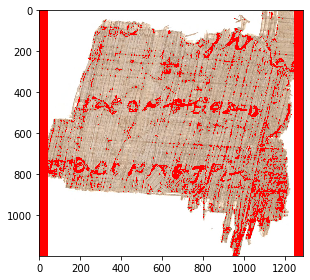

In [ ]:
masked = defect.copy()
masked[binary] = 1, 0, 0
io.imshow(masked)

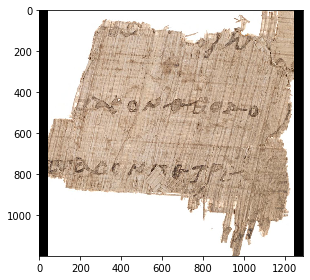

In [ ]:
io.imshow(defect)

In [ ]:
#@title Run this sell to set everything up
print('\n> Cloning the repo')
!git clone https://github.com/saic-mdal/lama.git

print('\n> Install dependencies')
!pip install -r lama/requirements.txt --quiet
!pip install wget --quiet

print('\n> Changing the dir to:')
% cd /content/lama

print('\n> Download the model')
!curl -L $(yadisk-direct https://disk.yandex.ru/d/ouP6l8VJ0HpMZg) -o big-lama.zip
!unzip big-lama.zip

print('>fixing opencv')
!pip uninstall opencv-python-headless -y --quiet
!pip install opencv-python-headless==4.1.2.30 --quiet


print('\n> Init mask-drawing code')
import base64, os
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
import numpy as np
import wget
from shutil import copyfile
import shutil



canvas_html = """
<style>
.button {
  background-color: #4CAF50;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>

<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)


> Cloning the repo
Cloning into 'lama'...
remote: Enumerating objects: 283, done.
remote: Counting objects: 100% (283/283), done.
remote: Compressing objects: 100% (205/205), done.
remote: Total 283 (delta 73), reused 264 (delta 66), pack-reused 0
Receiving objects: 100% (283/283), 6.49 MiB | 32.12 MiB/s, done.
Resolving deltas: 100% (73/73), done.

> Install dependencies
     |████████████████████████████████| 12.5 MB 5.2 MB/s 
     |████████████████████████████████| 22.3 MB 41.9 MB/s 
     |████████████████████████████████| 72 kB 514 kB/s 
     |████████████████████████████████| 144 kB 53.9 MB/s 
     |████████████████████████████████| 841 kB 43.1 MB/s 
     |████████████████████████████████| 271 kB 63.5 MB/s 
     |████████████████████████████████| 47 kB 662 kB/s 
     |████████████████████████████████| 47.7 MB 1.2 MB/s 
     |████████████████████████████████| 948 kB 43.6 MB/s 
     |████████████████████████████████| 74 kB 2.9 MB/s 
     |████████████████████████████████| 112 kB 56

In [ ]:
fname = None
#fname = 'https://ic.pics.livejournal.com/mostovoy/28566193/1224276/1224276_original.jpg' # <-in the example
# fname = 'https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/1010286.jpeg'
# fname = 'https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/1010287.jpeg'
# fname = "https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/alex.jpg"

In [ ]:
if fname is None:
  io.imsave('defect.jpg', defect)
  fname = 'defect.jpg'
else:
  fname = wget.download(fname)

In [ ]:
#@title Draw a Mask, Press Finish, Wait for Inpainting

shutil.rmtree('./data_for_prediction', ignore_errors=True)
! mkdir data_for_prediction

copyfile(fname, f'./data_for_prediction/{fname}')
os.remove(fname)
fname = f'./data_for_prediction/{fname}'

image64 = base64.b64encode(open(fname, 'rb').read())
image64 = image64.decode('utf-8')

print(f'Will use {fname} for inpainting')
img = np.array(plt.imread(f'{fname}')[:,:,:3])


Will use ./data_for_prediction/defect.jpg for inpainting


In [ ]:
draw(image64, filename=f"./{fname.split('.')[1]}_mask.png", w=img.shape[1], h=img.shape[0], line_width=0.04*img.shape[1])
#io.imsave('./data_for_prediction/defect_mask.png', masked)

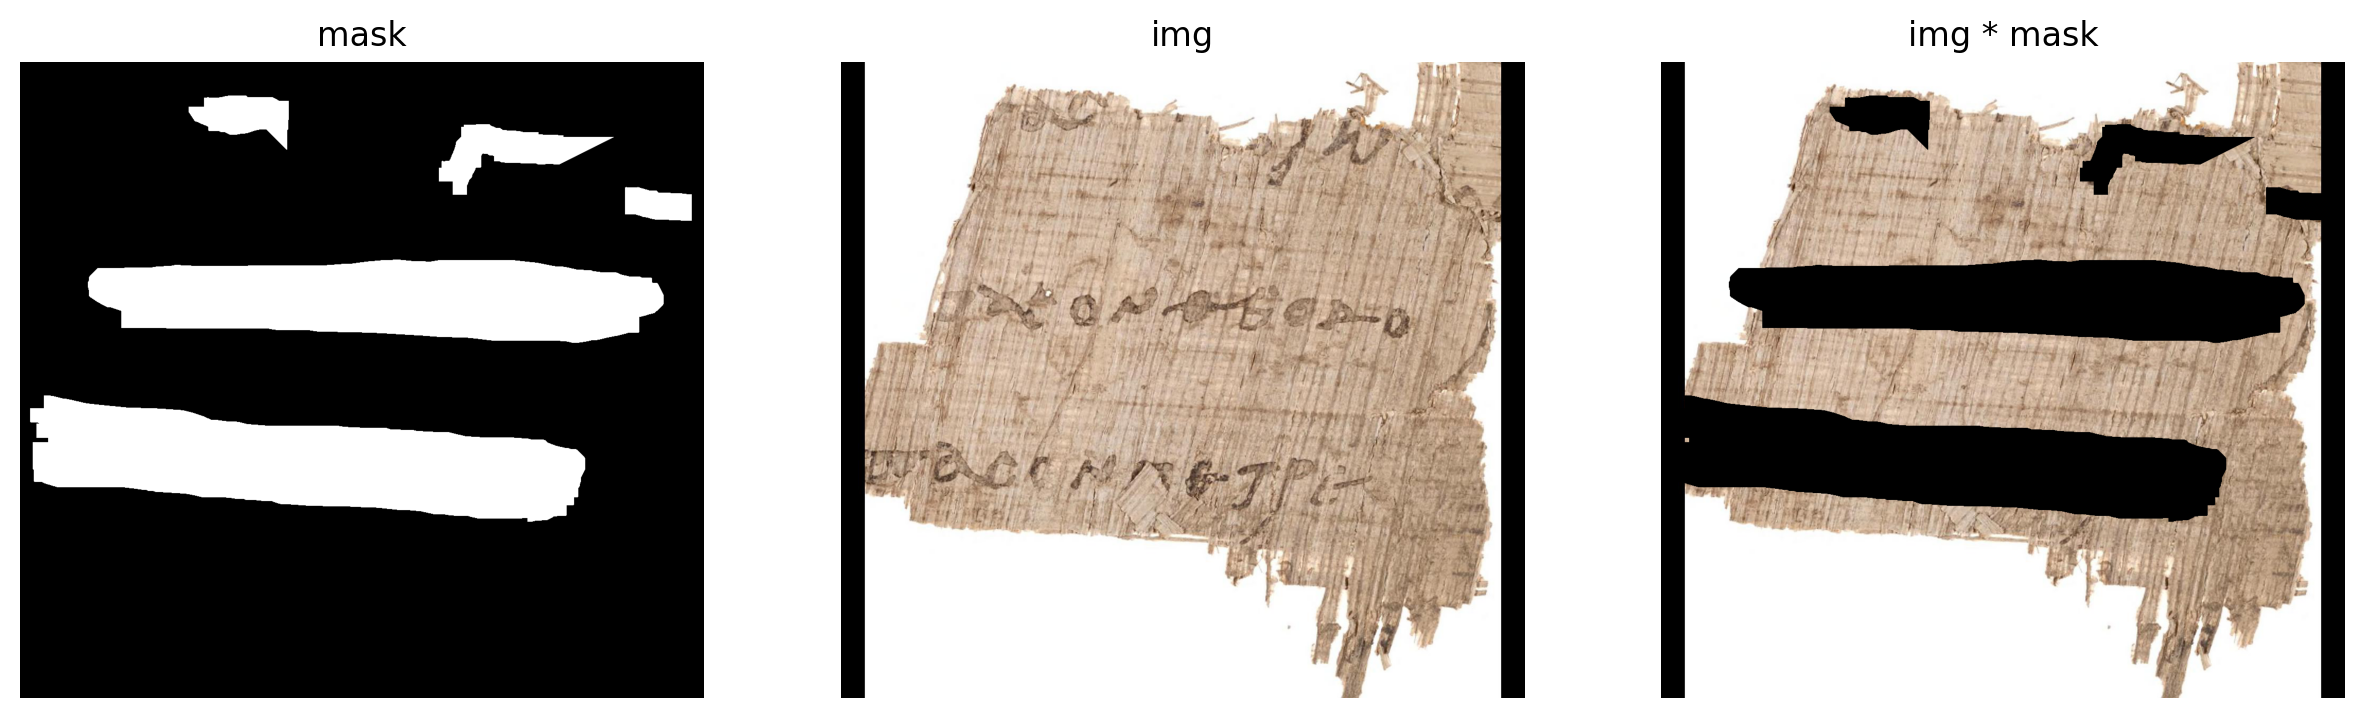

Run inpainting
100% 1/1 [00:00<00:00,  1.35it/s]


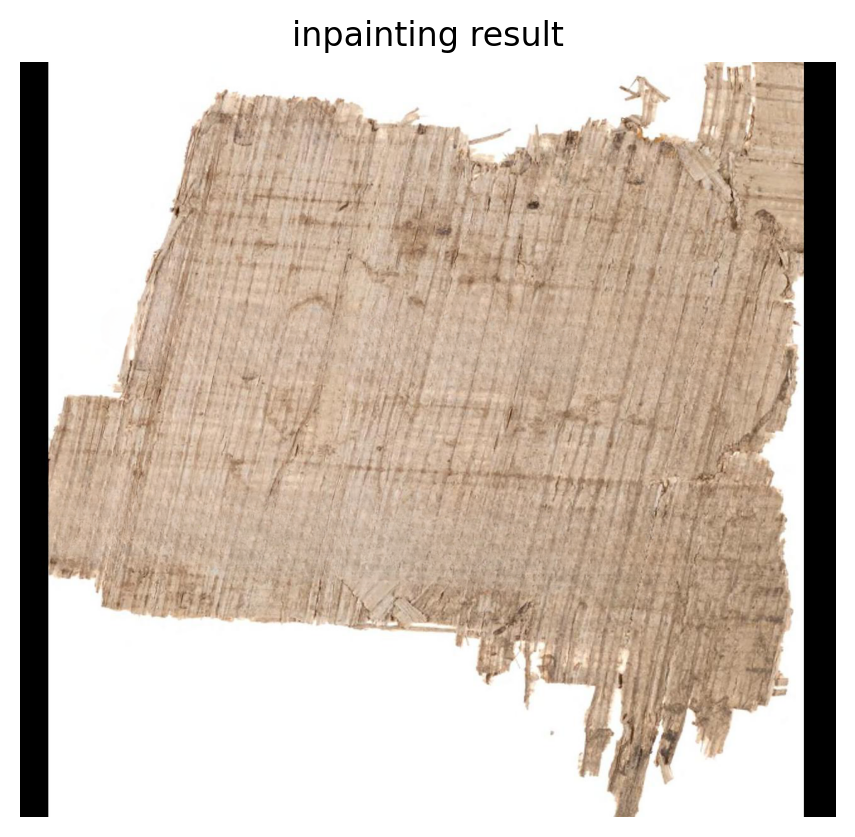

In [ ]:
#@title Show a masked image and save a mask
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['figure.dpi'] = 200
plt.subplot(131)
with_mask = np.array(plt.imread(f"./{fname.split('.')[1]}_mask.png")[:,:,:3])
mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('mask')
plt.imsave(f"./{fname.split('.')[1]}_mask.png",mask, cmap='gray')

plt.subplot(132)
img = np.array(plt.imread(f'{fname}')[:,:,:3])
plt.imshow(img)
plt.axis('off')
plt.title('img')

plt.subplot(133)
img = np.array((1-mask.reshape(mask.shape[0], mask.shape[1], -1))*plt.imread(fname)[:,:,:3])
_=plt.imshow(img)
_=plt.axis('off')
_=plt.title('img * mask')
plt.show()

print('Run inpainting')
if '.jpeg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output dataset.img_suffix=.jpeg > /dev/null
elif '.jpg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.jpg > /dev/null
elif '.png' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.png > /dev/null
else:
  print(f'Error: unknown suffix .{fname.split(".")[-1]} use [.png, .jpeg, .jpg]')

plt.rcParams['figure.dpi'] = 200
plt.imshow(plt.imread(f"/content/output/{fname.split('.')[1].split('/')[2]}_mask.png"))
_=plt.axis('off')
_=plt.title('inpainting result')
plt.show()
fname = None